# **An introduction of speech signal  processing in PyTorch**

### **Basic concepts**

**语音**：$Y[n] = A \sin(\omega x + b)$, A是幅度，b是相位，$\omega$ = 2 $\pi$ f <p>

**语音信号基本处理流程**：<p>
- 输入语音信号，首先进行分帧、预加重和加窗操作。
- 快速傅里叶变换（FFT）：对分帧后的信号进行快速傅里叶变换，得到 STFT 频谱（包括幅度和相位），即短时傅里叶变换频谱。
- 计算频谱：对复数频谱取绝对值或平方，得到幅度频谱或能量谱（Amplititude Spectrum），此时相位信息会被抹掉。
- 梅尔滤波（Mel滤波）：将频谱通过 Mel 滤波，得到梅尔频谱（Melspectrum）。
- 取对数：对梅尔频谱取对数，得到对数梅尔谱（Log melspectrum）。
- 离散余弦变换（DCT）：对对数梅尔谱进行 DCT，提取梅尔频率倒谱系数（MFCC），用于特征表示。
- 计算动态特征（Delta MFCC）：进一步计算 MFCC 的动态特征，输出最终的特征向量。<p>

**Remark:** 语音的深度学习一般使用Amplititude Spectrum和Melspectrum <p>

**Fourier transform的基本思想**: 把一维的语音信号，经过分帧，加窗等处理，再通过STFT可以得到每帧的一系列相位值和一系列幅度值。换而言之，以某种适当的
频率间隔将语音分解为一组基础信号，再利用FT算法计算出每组信号的幅度以及相位。即从一段信号（每帧）中，我们可以得到一组不同的基础信号的幅度以及频率。<p>
**语音信号长度：** 信号长度 = 采样时间Time x 采样率SR <p>
**帧数**：1 + 语音信号长度//hop_szie, 帧数与window length无关。<p>
**每帧有多少组基础信号：** 使用 *n_fft* 参数自己设置。若令*n_fft* = 256，则实际上设定了每帧129组频率不同的基础信号，这里129 = 1 + *n_fft* // 2。这里的频率依次为 1/T, 2/T,... 129/T, T = 窗长/sampling_rate。<p>

### **TorchAudio**

In [1]:
#sets the backend of matplotlib to the 'inline' backend
%matplotlib inline
import torch
import torchaudio
import requests
import matplotlib.pyplot as plt
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa
import numpy as np
import IPython.display as ipd

<Figure size 1500x500 with 0 Axes>

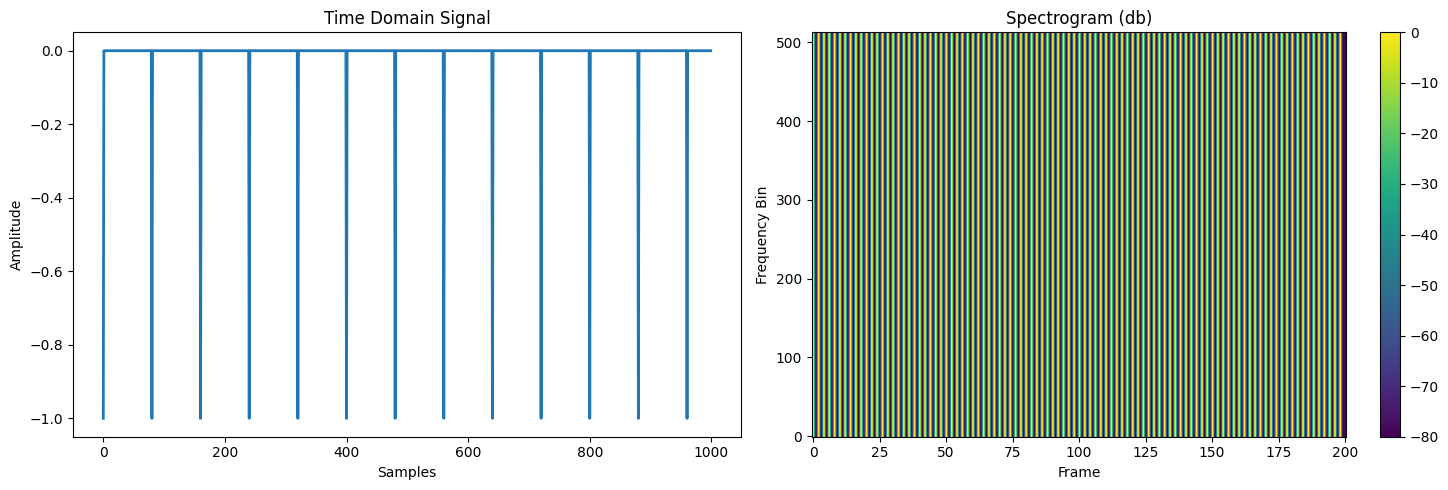

In [3]:
# 设置参数
F_s = 8000
e = np.zeros(int(F_s))  # 200ms at 8000 samples/second
for k in range(0, 100):  # 20 pitch periods
    e[k * 80] = -1

# 创建声谱图的函数
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1, figsize=(20, 5))
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    return plt

# 绘制时域信号
plt.figure(figsize=(15, 5))

# 创建一个包含两个子图的图形
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# 第一个子图：时域信号
axs[0].plot(e[0:1000], linewidth=2)
axs[0].set_title('Time Domain Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

# 提取声谱图
n_fft = 1024
spec_trans = T.Spectrogram(n_fft=n_fft, power=2, hop_length=40, win_length=80)
spec = spec_trans(torch.from_numpy(e))

# 第二个子图：声谱图
im = axs[1].imshow(librosa.power_to_db(spec.numpy()), origin="lower", aspect="auto")
axs[1].set_title('Spectrogram (db)')
axs[1].set_xlabel('Frame')
axs[1].set_ylabel('Frequency Bin')
fig.colorbar(im, ax=axs[1])

# 调整布局并显示
plt.tight_layout()
plt.show()

# 播放音频
ipd.display(ipd.Audio(e, rate=F_s))

### **Practice**
**语音信号特征获取流程**：
<p>
一条语音信号(时域，已知时间长度time，采样率sampling rate) <p>
-------> 设定window length，hop length，n_fft <p>
-------> 频域信号(二维, 张量形状为(维度，帧数)), 其中：维度(组数) = 1 + n_fft // 2, 帧数 = 1 + (Sampling_Rate*Time) // hop

In [6]:


wavform = torch.rand(1,16000)  # 这里的1代表一条语音，batch szie

## 由于一般使用‘信号点表示法’， 因此这里可以不设置采样率
## 注意：0 < window length <= n_fft
stft_function = torchaudio.transforms.Spectrogram(n_fft = 350, win_length = 320,hop_length = 160)

STFT_spec = stft_function(wavform)
print(STFT_spec.shape)

torch.Size([1, 176, 101])
